In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import torch
import torchvision
import torchaudio
from torchvision import transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.datapipes.iter import FileLister
import numpy as np
import os

In [16]:
import librosa

In [4]:
import torchvision.models as models

In [22]:
from torch.optim import lr_scheduler

In [5]:
train_folder = "../input/birdclef-2022/train_audio"

In [19]:
SAMPLE_RATE = 22050
NUM_SAMPLES = 22050
BATCH_SIZE = 4
EPOCHS = 5
LEARNING_RATE = 0.01
WORKERS = 2
NUM_CLASSES = 152

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
class BirdDataset(Dataset):
    def __init__(self, train_folder, transformation, sample_rate, num_samples):
        super().__init__()
        self.train_files_list = list(FileLister(root=train_folder, recursive=True))
        self.transformation = transformation
        self.sample_rate = sample_rate
        self.num_samples = num_samples
        
    def __len__(self):
        self.total_train_file = len(self.train_files_list)
        return self.total_train_file
        
    def list_all_files(self):
        return list(self.train_files_list)
    
    def _resample(self, signal, sr):
        if sr != self.sample_rate: 
            resampler = torchaudio.transforms.Resample(sr, self.sample_rate)
            signal = resampler(signal)
        return signal
    
    def _mix_channels(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
    
    def _right_padding(self,signal):
        if signal.shape[1] < self.num_samples:
            num_missing_samples = self.num_samples - signal.shape[1]
            last_dim_pad = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_pad)
        return signal
        
    def _crop(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal
        
    def __getitem__(self,index):
        filename = self.train_files_list[index]
        temp = filename.split(os.sep)
        label = temp[-2]
        signal, sr = torchaudio.load(filename)
        signal = self._resample(signal, sr)
        signal = self._mix_channels(signal)
        signal = self._right_padding(signal)
        signal = self._crop(signal)
        signal = self.transformation(signal)
        return signal[0],label

In [8]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64)

In [9]:
train_set = BirdDataset(train_folder, mel_spectrogram, SAMPLE_RATE, NUM_SAMPLES)

In [10]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
dataiter = iter(train_loader)
sample = dataiter.next()
s,l = sample
print(s)
print(l)

tensor([[[1.1351e-08, 1.0011e-06, 1.3986e-05,  ..., 7.1051e-06,
          3.6210e-05, 3.7032e-03],
         [1.6544e-09, 1.1011e-06, 8.0048e-05,  ..., 1.1245e-04,
          6.1187e-04, 4.5338e-03],
         [1.4451e-09, 2.1545e-07, 7.0249e-05,  ..., 6.1060e-04,
          2.5337e-04, 6.2311e-03],
         ...,
         [7.8519e-07, 1.4748e-05, 4.6037e-04,  ..., 3.7450e-05,
          4.6964e-04, 6.7020e-02],
         [9.2099e-07, 2.5524e-05, 2.2617e-04,  ..., 1.6806e-03,
          1.1847e-03, 5.1743e-02],
         [8.8758e-07, 1.6504e-05, 1.7948e-04,  ..., 1.0605e-02,
          5.1147e-03, 6.8015e-02]],

        [[9.7304e-06, 4.0919e-05, 1.0659e+00,  ..., 6.8684e+00,
          6.9917e+00, 7.1033e+00],
         [1.0624e-05, 8.9192e-05, 2.0519e+00,  ..., 9.1185e+00,
          8.5425e+00, 2.7625e+00],
         [5.0097e-07, 1.2275e-04, 8.9008e-01,  ..., 2.9044e-01,
          2.4426e-01, 1.3817e+00],
         ...,
         [1.5591e-06, 7.4617e-06, 1.4786e-02,  ..., 3.9386e-04,
          4.953

In [12]:
#s , r = train_set[2]

In [24]:
print(s)
print(l)

tensor([[[1.1351e-08, 1.0011e-06, 1.3986e-05,  ..., 7.1051e-06,
          3.6210e-05, 3.7032e-03],
         [1.6544e-09, 1.1011e-06, 8.0048e-05,  ..., 1.1245e-04,
          6.1187e-04, 4.5338e-03],
         [1.4451e-09, 2.1545e-07, 7.0249e-05,  ..., 6.1060e-04,
          2.5337e-04, 6.2311e-03],
         ...,
         [7.8519e-07, 1.4748e-05, 4.6037e-04,  ..., 3.7450e-05,
          4.6964e-04, 6.7020e-02],
         [9.2099e-07, 2.5524e-05, 2.2617e-04,  ..., 1.6806e-03,
          1.1847e-03, 5.1743e-02],
         [8.8758e-07, 1.6504e-05, 1.7948e-04,  ..., 1.0605e-02,
          5.1147e-03, 6.8015e-02]],

        [[9.7304e-06, 4.0919e-05, 1.0659e+00,  ..., 6.8684e+00,
          6.9917e+00, 7.1033e+00],
         [1.0624e-05, 8.9192e-05, 2.0519e+00,  ..., 9.1185e+00,
          8.5425e+00, 2.7625e+00],
         [5.0097e-07, 1.2275e-04, 8.9008e-01,  ..., 2.9044e-01,
          2.4426e-01, 1.3817e+00],
         ...,
         [1.5591e-06, 7.4617e-06, 1.4786e-02,  ..., 3.9386e-04,
          4.953

In [15]:
s.shape

torch.Size([4, 64, 44])

In [17]:
def plot_spectrogram(spec, xmax=None):
    fig, axs = plt.subplots(1, 1, figsize=(10,4))
    axs.set_title("Mel-Spectrogram")
    axs.set_ylabel("mel-freq")
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect="auto")
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

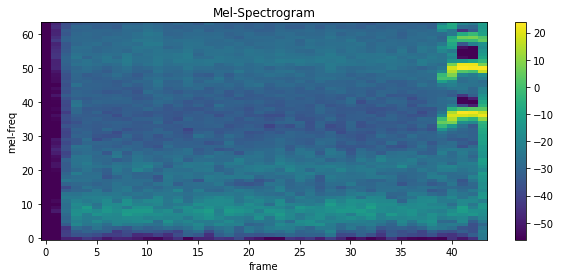

In [18]:
plot_spectrogram(s[0])

In [20]:
def get_model():
    model = models.resnet18(pretrained=True)
    num_ftrs_last_layer = model.fc.in_features
    
    model.fc = nn.Linear(num_ftrs_last_layer, NUM_CLASSES)
    return model

In [23]:
model = get_model()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

lr_step_sched = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]